# Debugging Model Generalization
Here we will look at what the models are predicting for particular trajectories.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import six
import dynamics_model_class as dmc
import mcts_tests as mc
import mcts
import numpy as np
import scipy as sp
from matplotlib.pyplot import *
import dataset_utils
import tensorflow as tf
import tflearn
import copy

from concept_dependency_graph import ConceptDependencyGraph
import data_generator as dg
from student import *
import simple_mdp as sm

In [3]:
n_concepts = 5
use_student2 = True
transition_after = True
student2_str = ('2' if use_student2 else '') + ('a' if use_student2 and transition_after else '')
learn_prob = 0.5
lp_str = '-lp{}'.format(int(learn_prob*100)) if not use_student2 else ''
n_students = 100000
seqlen = 8
filter_mastery = False
filter_str = '' if not filter_mastery else '-filtered'
policy = 'random'
epsilon = 0.3
epsilon_str = '{:.2f}'.format(epsilon) if policy == 'egreedy' else ''
filename = 'test{}-w{}-n{}-l{}{}-{}{}{}.pickle'.format(student2_str, n_concepts, n_students, seqlen,
                                                    lp_str, policy, epsilon_str, filter_str)
concept_tree = ConceptDependencyGraph()
concept_tree.init_default_tree(n_concepts)
if not use_student2:
    test_student = Student(n=n_concepts,p_trans_satisfied=learn_prob, p_trans_not_satisfied=0.0, p_get_ex_correct_if_concepts_learned=1.0)
else:
    test_student = Student2(n_concepts, transition_after=transition_after)
six.print_(filename)

test2a-w5-n100000-l8-random.pickle


In [4]:
# load data
data = dataset_utils.load_data(filename='{}{}'.format(dg.SYN_DATA_DIR, filename))

In [5]:
print('Average posttest: {}'.format(sm.expected_reward(data)))
print('Average sparse reward: {}'.format(sm.expected_sparse_reward(data)))
print('Percent of full posttest score: {}'.format(sm.percent_complete(data)))
print('Percent of all seen: {}'.format(sm.percent_all_seen(data)))
for t in data[0]:
    six.print_(t)
# find trajectories that end with everything learned
all_learned = []
for ix, traj in enumerate(data):
    last_knowledge = traj[-1][2]
    if np.sum(last_knowledge) > n_concepts - 0.5:
        all_learned.append(ix)
six.print_(len(all_learned))
six.print_(all_learned)

Average posttest: 0.421166
Average sparse reward: 0.00041
Percent of full posttest score: 0.00041
Percent of all seen: 0.4283
(array([ 0.,  0.,  0.,  0.,  1.]), False, array([ 1.,  0.,  0.,  0.,  0.]), array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0]))
(array([ 1.,  0.,  0.,  0.,  0.]), True, array([ 1.,  0.,  0.,  0.,  0.]), array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0]))
(array([ 0.,  0.,  0.,  1.,  0.]), False, array([ 1.,  0.,  0.,  0.,  0.]), array([1, 0, 0, 0, 0, 1, 0, 0, 0, 0]))
(array([ 1.,  0.,  0.,  0.,  0.]), True, array([ 1.,  0.,  0.,  0.,  0.]), array([1, 0, 0, 0, 0, 1, 0, 0, 0, 0]))
(array([ 0.,  0.,  0.,  1.,  0.]), False, array([ 1.,  0.,  0.,  0.,  0.]), array([1, 0, 0, 0, 0, 1, 0, 0, 0, 0]))
(array([ 1.,  0.,  0.,  0.,  0.]), True, array([ 1.,  0.,  0.,  0.,  0.]), array([1, 0, 0, 0, 0, 1, 0, 0, 0, 0]))
(array([ 1.,  0.,  0.,  0.,  0.]), True, array([ 1.,  0.,  0.,  0.,  0.]), array([1, 0, 0, 0, 0, 1, 0, 0, 0, 0]))
(array([ 0.,  0.,  0.,  0.,  1.]), False, array([ 1.,  0.,  0.,  0.,  0.]

In [6]:
input_data_, output_mask_, target_data_ = dataset_utils.preprocess_data_for_rnn(data)
train_data = (input_data_[:,:,:], output_mask_[:,:,:], target_data_[:,:,:])
six.print_(input_data_.shape)
six.print_(output_mask_.shape)
six.print_(target_data_.shape)
six.print_(input_data_[0,:,:])
six.print_(output_mask_[0,:,:])
six.print_(target_data_[0,:,:])

(100000, 7, 10)
(100000, 7, 5)
(100000, 7, 5)
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
[[ 1.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.]
 [ 1.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.]
 [ 1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.]]
[[ 1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]]


vloss shape (50, 11)
scores shape (50,)
 0: AUC 0.0024 score 1.00
 1: AUC 0.0025 score 1.00
 2: AUC 0.0016 score 1.00
 3: AUC 0.0017 score 1.00
 4: AUC 0.0012 score 1.00
 5: AUC 0.0018 score 1.00
 6: AUC 0.0018 score 0.00
 7: AUC 0.0021 score 0.25
 8: AUC 0.0021 score 1.00
 9: AUC 0.0028 score 1.00
10: AUC 0.0023 score 0.00
11: AUC 0.0012 score 1.00
12: AUC 0.0017 score 1.00
13: AUC 0.0021 score 0.00
14: AUC 0.0022 score 1.00
15: AUC 0.0028 score 0.00
16: AUC 0.0024 score 1.00
17: AUC 0.0017 score 1.00
18: AUC 0.0021 score 0.00
19: AUC 0.0025 score 0.00
20: AUC 0.0145 score 0.75
21: AUC 0.0102 score 0.00
22: AUC 0.0099 score 0.00
23: AUC 0.0135 score 0.00
24: AUC 0.0114 score 0.00
25: AUC 0.0085 score 1.00
26: AUC 0.0102 score 0.00
27: AUC 0.0100 score 0.00
28: AUC 0.0106 score 0.00
29: AUC 0.0124 score 1.00
30: AUC 0.0120 score 0.00
31: AUC 0.0134 score 1.00
32: AUC 0.0137 score 1.00
33: AUC 0.0134 score 0.00
34: AUC 0.0116 score 0.00
35: AUC 0.0100 score 0.00
36: AUC 0.0119 score 0.0

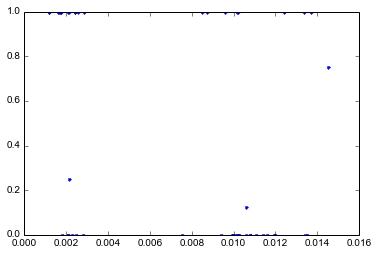

In [7]:
'''
Analyzing results of student2 with 5 skills, with training length 7 and testing length 8.
Single LSTM
'''
data11 = np.load('experiments/test2w5_modelsimple_mid-dropout10-shuffle1-data-test2a-w5-n100000-l7-random.pickle/stats-runB.npz')
data12 = np.load('experiments/test2w5_modelsimple_mid-dropout10-shuffle1-data-test2a-w5-n100000-l7-random.pickle/stats-runC.npz')
data21 = np.load('experiments/test2w5_modelsimple_mid-dropout10-shuffle1-data-test2a-w5-n100000-l7-random.pickle/mcts-rtype2-rollouts20000-trajectories8-real1-runB.npz')
data22 = np.load('experiments/test2w5_modelsimple_mid-dropout10-shuffle1-data-test2a-w5-n100000-l7-random.pickle/mcts-rtype2-rollouts20000-trajectories8-real1-runC.npz')

vloss = np.vstack((data11['vloss'],data12['vloss']))
scores = np.vstack((data21['scores'],data22['scores']))[:,0]
#qvals = np.vstack((data21['qvals'],data22['qvals']))[:,0]

six.print_('vloss shape {}'.format(vloss.shape))
six.print_('scores shape {}'.format(scores.shape))
for i in six.moves.range(scores.shape[0]):
    six.print_('{:2d}: AUC {:.4f} score {:.2f}'.format(i, np.sum(vloss[i,:]), scores[i]))

plot(np.sum(vloss,axis=1), scores, '.')
# from the own qvalues, it seems like as a general rule (though not absolute), larger qvals at the end correspond to better policy-models
# 21 / 50

In [9]:
dmodel = dmc.DynamicsModel(model_id='test2w5_modelsimple_mid', timesteps=seqlen+2, dropout=1.0, load_checkpoint=False)
dmodel.load('experiments/test2w5_modelsimple_mid-dropout10-shuffle1-data-test2a-w5-n100000-l7-random.pickle/checkpoint-runB6-epoch10')

Loading RNN dynamics model...
Directory path for tensorboard summaries: ../tensorboard_logs/test2w5_modelsimple_mid/
Checkpoint directory path: ../checkpoints/test2w5_modelsimple_mid/
Model loaded.
INFO:tensorflow:Restoring parameters from /usr0/home/zguo/Documents/smart-tutor/code/experiments/test2w5_modelsimple_mid-dropout10-shuffle1-data-test2a-w5-n100000-l7-random.pickle/checkpoint-runB6-epoch10


In [11]:
# predict a bit
dataix = all_learned[1]
test_input_data = input_data_[dataix:dataix+1,:,:]
prediction = dmodel.predict(test_input_data)[0,:,:]

# print out the predictions after every step
curr_data = data[dataix]
for t in six.moves.range(7):
    six.print_('Step {}'.format(t+1))
    six.print_('State             [{}]'.format(''.join('{:7d}'.format(int(x)) for x in curr_data[t][3])))
    six.print_('Action:           [{}]'.format(''.join('{:7d}'.format(int(x)) for x in curr_data[t][0])))
    six.print_('Correct? {}'.format(curr_data[t][1]))
    six.print_('Knowledge After:  [{}]'.format(''.join('{:7d}'.format(int(x)) for x in curr_data[t][2])))
    six.print_('Model Prediction: [{}]'.format(''.join('{:7.2f}'.format(x) for x in prediction[t,:])))
    six.print_()

six.print_('-- Step 8 ----------------------------------------------------------')

# add one observation of each action and see what the predictions turn into
for nexta in six.moves.range(n_concepts):
    actvec = np.zeros((n_concepts,),dtype=np.int)
    actvec[nexta] = 1
    obvec = np.zeros((n_concepts*2,))
    if data[dataix][6][2][nexta] == 1:
        obvec[nexta] = 1.0
    else:
        obvec[nexta + 5] = 1.0
    six.print_('Action:           [{}]'.format(''.join('{:7d}'.format(int(x)) for x in actvec)))
    six.print_('Correct? {}'.format(data[dataix][6][2][nexta]))
    #six.print_('Observation:      [{}]'.format(''.join('{:7d}'.format(int(x)) for x in obvec)))
    test_input_data2 = np.vstack((test_input_data[0,:,:],obvec[np.newaxis,:]))
    prediction = dmodel.predict(test_input_data2[np.newaxis,:,:])
    six.print_('Model Prediction: [{}]'.format(''.join('{:7.2f}'.format(x) for x in prediction[0,7,:])))
    six.print_()
# observations
# sometimes, even though a skill is tested twice, the model doesn't believe it is learned
# also if the actions are temporally separated, it seems like the model isn't properly remembering what it has done before
# seems like skill 3 is hard to learn properly
# also there is still forgetting behavior being learned where testing one problem can reduce the probability of getting another one correct
# so it really looks like the central issue is forgetting, and nonindependence
# is this caused by overfitting?
# maybe need to enlarge the minibatch size by a lot

Step 1
State             [      1      0      0      0      0      0      0      0      0      0]
Action:           [      0      1      0      0      0]
Correct? False
Knowledge After:  [      1      0      0      0      0]
Model Prediction: [   1.00   0.00   0.00   0.00   0.00]

Step 2
State             [      1      0      0      0      0      0      1      0      0      0]
Action:           [      0      0      1      0      0]
Correct? False
Knowledge After:  [      1      0      0      0      0]
Model Prediction: [   1.00   0.00   0.00   0.00   0.00]

Step 3
State             [      1      0      0      0      0      0      1      1      0      0]
Action:           [      0      1      0      0      0]
Correct? False
Knowledge After:  [      1      1      0      0      0]
Model Prediction: [   1.00   1.00   0.00   0.00   0.00]

Step 4
State             [      1      1      0      0      0      0      1      1      0      0]
Action:           [      0      0      0      0      1]
